# The LondON Precipitation Project
<hr />
<img src ="../images/cumulonimbus.jpg" style="height: 400px;" />


## 1.1 Project Goals
The primary goal of this analysis is to answer the investigate question of whether or not London Ontario has experienced **unusual precipitation in 2017 than in previous years** and if so, by how much.  It's obvious that London, ON has had some sort of bizarre precipitation year, weather it be multiple days of high precipitation or higher total precipitation, average precipitation, or all three.  But there seems to not exist sources that:

    1. Quantitatively describe the magnitude of the change
    2. Identify more subtle variations such as changing states of discrete events counts over time


Log-transformed data will be sufficient for [T-tests](https://en.wikipedia.org/wiki/Student%27s_t-test) and [ANOVA](#http://vassarstats.net/textbook/ch13pt1.html) (statistical methods to identify _statistically significant changes_ in year-over-year precipitation levels) 

to determine if we've received _significantly_ more rain, this analyis is limited to visualizations and summary statistics.  These methods will be sufficient in answering our primary research question of weather or not it has rained more this year than in previous years and by how much.

The secondary goal is to create a generative model that attempts to model the [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) of high-precipitation or rainy days.  A probabilistic model can be used to estimate the probability, with a quantifiable measurable of uncertainty, of observing one, two, three, up to seven rainy days in a seven day period (one week).  In capturing how this weekly frequency changes over time, we can answer questions like "Is it raining more frequently on a weekly basis?" or "What is the probability that it will rain 5/7 days next week?"

## 1.2 Data
### Description
Climate Canada provides access to historical weather data through its historical climate data [web app](http://climate.weather.gc.ca/historical_data/search_historic_data_e.html).  The data is produced by sensors at various [weather stations](https://en.wikipedia.org/wiki/Weather_station) at geographically dispersed locations accross Canada.

> A **weather station** is a facility, either on land or sea, with instruments and equipment for measuring atmospheric conditions to provide information for weather forecasts and to study the weather and climate.

Data is available at monthly, daily, and hourly intervals on a per-weather station basis with data missing for some combinations of interval, station, and timeframe.  E.g. monthly data for London weather stations, data aggregated up to the monthly level, is generally not available but daily data is.  The availability for a particular time interval (e.g. for the month of December) varies accross stations; some stations are missing entire months of data.  This will not pose a significant problem as we are not interested in station-level measurements but rather overall weather trends in London.  Data accross stations is aggregated so that the daily measurements from each station are averaged to produce a single measurement value (see [1.5](#1.5-Daily-Observation-Data)).  When data is missing from one station, it is generally available from another.

The different time intervals (monthly, daily, hourly) provide different measurements.  Daily weather data (availalable through the Climate Canada website by year/month) contains both precipitation and weather data and is the most suitable level of granularity for this analysis so it's the level of granularity that will be used for this analysis.  The variables are described below and are explained below[[1](http://climate.weather.gc.ca/glossary_e.html)].


  Measurement        | Description
---------------------| -------------
maxTemp		         | [Description]					
minTemp		         | [Description]					
meanTemp	         | [Description]						
heatDegDays			 | [Description]							
coolDegDays			 | [Description]							
totalRainMM			 | [Description]							
totalSnowCM			 | [Description]							
totalPrecipMM		 | [Description]								
snowOnGroundCM		 | [Description]									
dirOfMaxGust10sDEG	 | [Description]											
spdOfMaxGustKMH		 | [Description]									


### Retrieving Weather Data
Historical weather data produced by weather stations can be obtained through Climate Canada's search system that accepts queries for station names, province, or proximity as shown below.

<img src ="../images/station_search.png" style="height: 400px;" />

After selecting a station, data can be requested at hourly, daily, or monthly intervals.

<img src ="../images/station_result.png" style="height: 400px;" />

This analysis will focus on data from weather stations deployed in London Ontario, Canada so the search term used to find relevant stations and the associated data included only the keyword "London".  

After using the Climate Canada web app to identify stations in London Ontario, only those with monthly data (data for every day of the month) available for at least five years were considered for the analysis.  The London CS, London Airport, and London A stations met this critera and monthly data for the stations were retrieved from Climate Canada's web application using a Python program built using the web scraping framework [Scrapy](#).  The program automates the data retrieval process by generating search requests for station data for these stations for every month from January 1, 2012 to July 13, 2017 and uses [XPath](https://msdn.microsoft.com/en-us/library/ms256086(v=vs.110).aspx) to extract data from the HTML table show below.  

<img src ="../images/station_report.png" style="height: 400px;" />

All of the data is appended to a CSV file where each row represents a day of observed data from each one of the stations.  Code for the web scraper can be found [here](#).  For the ambitious reader, the data can be populated with data upto today's date by running the folllowing at the command line:

```
cd ../webcrawler
scrapy crawl daily_spider
```

In [32]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [33]:
# Load daily weather data produced by web scraper
dwd = pd.read_csv("../data/scrapy_2017-07-22.csv")

In [34]:
pd.DataFrame(index=dwd.describe().transpose().index)

""
station
date
maxTemp
minTemp
meanTemp
heatDegDays
coolDegDays
totalRainMM
totalSnowCM
totalPrecipMM


Look at the first few observations

In [35]:
dwd.head()

,station,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH
0,London A,2010-03-01,,,,,,,,,,,
1,London A,2010-03-02,,,,,,,,,,,
2,London A,2010-03-03,,,,,,,,,,,
3,London A,2010-03-04,,,,,,,,,,,
4,London A,2010-03-05,,,,,,,,,,,


It's obvious that there's some missing data.  As observed while exploring data through the website, some measurements include an empty value while others include the value 'M'.

In [36]:
dwd.shape

(6179, 13)

6133 observatiions, 13 variables

In [37]:
dwd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6179 entries, 0 to 6178
Data columns (total 13 columns):
station               6179 non-null object
date                  6179 non-null object
maxTemp               6153 non-null object
minTemp               6162 non-null object
meanTemp              6142 non-null object
heatDegDays           6142 non-null object
coolDegDays           6142 non-null object
totalRainMM           1458 non-null object
totalSnowCM           1296 non-null object
totalPrecipMM         4004 non-null object
snowOnGroundCM        6016 non-null object
dirOfMaxGust10sDEG    3427 non-null object
spdOfMaxGustKMH       3427 non-null object
dtypes: object(13)
memory usage: 627.6+ KB


In [56]:
print("{} to {}".format(dwd.date.min(), dwd.date.max()))

2010-01-01 to 2017-07-21


## 1.3 Data Prep

Transform the columns to the appropriate data types

In [38]:
# Discrete columns
disc = ['station', 'date']

In [39]:
# Continuous data with empty values replaced with None
data_cont = pd.DataFrame.replace(
  pd.DataFrame(dwd[dwd.columns.drop(disc)]),
  ["\xa0", "<31"],
  ["NaN", 31]).astype(float)
data_disc = dwd[disc]

Discrete

In [40]:
pd.DataFrame(index=disc)

""
station
date


Continuous

In [41]:
pd.DataFrame(index=data_cont.columns)

""
maxTemp
minTemp
meanTemp
heatDegDays
coolDegDays
totalRainMM
totalSnowCM
totalPrecipMM
snowOnGroundCM
dirOfMaxGust10sDEG


Final dataset

In [42]:
df = pd.concat([data_cont, data_disc], axis=1)

Summary statistics

In [43]:
cm = sns.light_palette("red", as_cmap=True)
s = df.describe().transpose().style.background_gradient(cmap=cm)
s

,count,mean,std,min,25%,50%,75%,max
maxTemp,4686,13.4396,11.6404,-19,3.7,14.7,23.875,36.7
minTemp,4695,3.4183,10.1215,-30.5,-3.3,3.6,11.7,24.6
meanTemp,4675,8.44047,10.7376,-24.5,0.3,9.1,17.8,30.7
heatDegDays,4675,10.3746,9.74878,0,0.2,8.9,17.7,42.5
coolDegDays,4675,0.81508,1.82779,0,0,0,0,12.7
totalRainMM,1243,1.55559,4.48242,0,0,0,0,39.3
totalSnowCM,1081,1.28992,3.10682,0,0,0,1,35
totalPrecipMM,3789,2.69942,5.97551,0,0,0,2.5,69.7
snowOnGroundCM,1553,7.86413,10.6616,0,0,3,11,59
dirOfMaxGust10sDEG,124,20.4597,10.2833,1,13,20,30,36


* Highest observed temperature is 36.7°C
* Minimum observed temperature is -30.5°C
* Average observed temperature is 8.3°C
* All variables except for temperature-related variables are strictly positive
* Temperature varries more than precipitation

## 1.4 Missing Data

Measurements from sensors produced at weather station locations are [noisy](http://climate.weather.gc.ca/climate_data/data_quality_e.html) i.e. values may be innacurate or they  may be missing.

How many records are missing measurements?

In [44]:
df.isnull().sum()

maxTemp               1493
minTemp               1484
meanTemp              1504
heatDegDays           1504
coolDegDays           1504
totalRainMM           4936
totalSnowCM           5098
totalPrecipMM         2390
snowOnGroundCM        4626
dirOfMaxGust10sDEG    6055
spdOfMaxGustKMH       4219
station                  0
date                     0
dtype: int64

In [45]:
df.isnull().sum() / len(df)

maxTemp               0.241625
minTemp               0.240168
meanTemp              0.243405
heatDegDays           0.243405
coolDegDays           0.243405
totalRainMM           0.798835
totalSnowCM           0.825053
totalPrecipMM         0.386794
snowOnGroundCM        0.748665
dirOfMaxGust10sDEG    0.979932
spdOfMaxGustKMH       0.682797
station               0.000000
date                  0.000000
dtype: float64

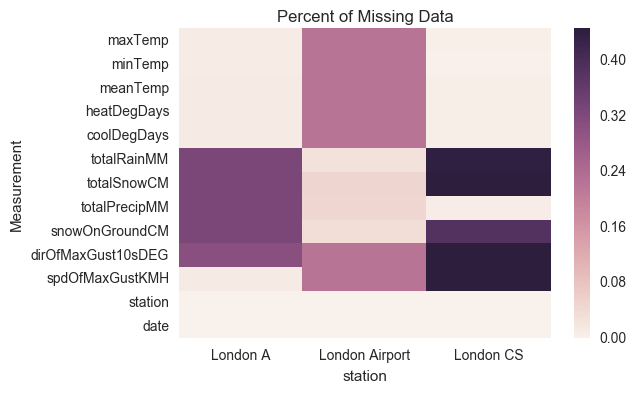

In [46]:
_ = sns.heatmap((df.groupby('station').apply(lambda x: pd.isnull(x).sum()) / df.shape[0]).transpose())
_.set_title("Percent of Missing Data");
_.set_ylabel("Measurement");

* The **London A** is missing precipitation data but not much else
* The **London Airport** station is missing temperature and wind data but has most complete rain data
* The **London CS** is missing significant wind, rain, and snow measurements

The only variable with a significant number of missing values accross stations is `dirOfMaxGust10sDEG`.  With a sufficient amount of available data from a combination of the three stations for all other relevant variables, we can summarize the measurements using the arithmetic mean of each measurement $m$ at each station $S$ at each time $t$.

## 1.5 Daily Observation Data
Since we are not ultimately not interested in measurements from individual weather stations (the purpose of this analysis is to analyze precipitation trends in London Ontario as a whole), we can collapse observations from different locations into a single measurement.  We could consider using the mean or the median as a summary statistic but for the purposes of this analysis, we'll use the mean since the measurements from the various station averages do not vary too much (?).

In [47]:
by_date_df = df.groupby('date').mean()
by_date_df.head()

,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH
date,,,,,,,,,,,
2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN
2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN
2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN
2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN
2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN


In [58]:
print("{} to {}".format(by_date_df.index.min(), by_date_df.index.max()))

2010-01-01 to 2017-07-21


In [63]:
# Save the data
csv_name = "../data/notebook1_weather_by_day_{}.csv".format(by_date_df.index.max())
by_date_df.to_csv(csv_name)
by_date_df_csv = pd.read_csv(csv_name, date_parser=['date'])
print(csv_name)
print(by_date_df_csv.info())
by_date_df_csv.head()

../data/notebook1_weather_by_day_2017-07-21.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759 entries, 0 to 2758
Data columns (total 12 columns):
date                  2759 non-null object
maxTemp               2758 non-null float64
minTemp               2759 non-null float64
meanTemp              2758 non-null float64
heatDegDays           2758 non-null float64
coolDegDays           2758 non-null float64
totalRainMM           1208 non-null float64
totalSnowCM           1081 non-null float64
totalPrecipMM         2720 non-null float64
snowOnGroundCM        1201 non-null float64
dirOfMaxGust10sDEG    124 non-null float64
spdOfMaxGustKMH       1953 non-null float64
dtypes: float64(11), object(1)
memory usage: 258.7+ KB
None


,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH
0,2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN
1,2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN
2,2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN
3,2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN
4,2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN
